# Lab 1: POD Space-time separation

#### Objective: 

Solving the transient 1D heat conduction equation of a bar using the numerical techniques.As the analysis is transient, we need to solve a time stepping algorithm which is the time consuming part of the analysis, Therefore we consider time as a parameter for this parametric study.

Model Order Reduction aims at reducing the complexity of the numerical model at hand without simplifying the underlying physics. The key idea of replacing the generic approximation spaces with problem specific ones be learning from the data by setting up a optimization problem.

Let u : u(x,t) be the temperature distribution in a bar of length L and during a time interval of interest T.

Temperature is governed by the equation:


$$
\rho \cdot Cp \cdot \frac{\partial u}{\partial t} - k \cdot \frac{\partial^2 u}{\partial x^2} = s(x,t)
$$


 where $\rho$ is the density, Cp is the specific heat and k is the material conductivity.

 #### Finite Element Formulation: 

The given equation is in strong form. Now to convert this equation to week form, We integrate above equation over the domain which is 1D in our case by multiplying with test function. We choose test function such that it satifies the dirichlet boundary condition. The weak form reduces the continuity requirements on the basis functions used for approximation which gives way to using lesser degree polynomials. 

$$
\rho \cdot Cp \cdot \frac{\partial u}{\partial t} - k \cdot \frac{\partial^2 u}{\partial x^2} = s(x,t)
$$


$$
\int_x (\rho * Cp *  \frac{\partial u}{\partial t} * v - k* \frac{\partial^2 u}{\partial x^2} * v ) \mathrm{dx} = \int_x (s(x,t) * v) \mathrm{dx}
$$

K is conductivity and is independent of the temperature.

By applying the Integration by parts,
$$
\rho * Cp *   \int_{x}   v \mathrm{dx}  (\frac{\partial u}{\partial t}) + k* \int_{x} (\frac{\partial u}{\partial x} * \frac{\partial v}{\partial x} ) \mathrm{dx} = \int_x (s(x,t) * v) \mathrm{dx} + [v \frac{\partial u}{\partial x}]_{x2} - [v \frac{\partial u}{\partial x}]_{x1}
$$

v(x1) = 0

therefore, equation reduces to: 

$$
\rho * Cp *   \int_{x }  v \mathrm{dx} (\frac{\partial u}{\partial t}) + k* \int_{x } (\frac{\partial u}{\partial x} * \frac{\partial v}{\partial x} ) \mathrm{dx} = \int_\Omega (s(x,t) * v) \mathrm{dx} + [v \frac{\partial u}{\partial x}]_{x2} 
$$
$$
C_{element} = \rho * Cp *   \int_x  v \mathrm{dx}
$$

$$
K_{\text{element}} = k \cdot \int_{x} \left(\frac{\partial u}{\partial x} \cdot \frac{\partial v}{\partial x}\right) \, \mathrm{dx}
$$


$$
\
f(t)_{element}  = \int_{x} (s(x,t) * v) \mathrm{d}x + [v \frac{\partial u}{\partial x}]_{x2}
\
$$

By substituting the approximation function, we obtain a elemental stiffness and damping matrix, by assemblying we obtain the global matrices C, K, f(t).

The week form that is obtained is:
$$
C * \frac{\partial u}{\partial t} + K * u(t) = f(t)
$$

where, C is a damping matrix, K is a stiffness matrix

$$
f(t) = M \cdot s(t) + q(t)
$$



where:
\begin{align*}
q(t) &= [q_L(t), 0, 0, \ldots, 0, q_R(t)] \\
\end{align*}

From the given boundary conditions (explained later), we can see that the initial condition of temperature is provided. We can solve the weak form using time integration schemes.


We use the \(\theta\) method in the spatial derivatives:

$$
C \cdot \left(\frac{U_{k+1} - U_k}{dt}\right) + K \cdot \left((\theta U_{k+1}) + (1-\theta) U_k\right) = (\theta f_{k+1}) + (1-\theta) f_k
$$


By interchanging the values:

$$
U_{k+1} = G^{-1} b
$$

where,
$$
G = C + \theta \Delta t K
$$

$$
b = \left(C - (1-\theta) \Delta t K\right) U_k + \Delta t f'
$$

$$
f' = f_k + \theta (f_{k+1} - f_k)
$$

All the necessary libraries are imported

In [ ]:
import os
import numpy as np
import warnings
from scipy import sparse
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg

## Routines to generate FEM solutions

The function FEM_mat_1D is the Finite Element Formulation which computes the resultant stiffness and damping matrices.

In [ ]:
def FEM_mat_1D(x, op1, op2, lin_fields=None):
    """
    Generates 1D FEM operators
    x is the array containing dof coordinates (1D)
    op1, op2 indicate order of derivative (0 or 1) in the bilinear form
    lin_fields is optional, contains constitutive coefficients e.g. conductivity, density, etc. that vary linearly within the element.
    """
    assert isinstance(x, np.ndarray), "x should be numpy 1D array"
    assert x.ndim == 1, "x should be a 1D array"
    if lin_fields is None:
        lin_fields = np.empty([0, 0])
    Nnodes = x.size
    Nelem = Nnodes - 1

    # Connectivity
    T10 = np.column_stack([np.arange(0, Nnodes - 1), np.arange(1, Nnodes)])

    # Shape functions
    Lin_shp = [None, None]
    Lin_shp[0] = lambda xi, Xe: np.vstack([(1 - xi) / 2, (1 + xi) / 2]) 
    Lin_shp[1] = lambda xi, Xe: np.vstack(                              
        [-np.ones(xi.size) / (Xe[1] - Xe[0]), np.ones(xi.size) / (Xe[1] - Xe[0])]
    )

    # Interpolator to gauss points
    Lin_eval = lambda xi, Xe: (Xe[0] * (1 - xi) + Xe[1] * (1 + xi)) / 2
    # Jacobian
    Jac = lambda Xe: (Xe[1] - Xe[0]) / 2
    # Gauss points & weights
    xi_integ = np.array([0.774596669241483, 0.0, -0.774596669241483])
    w_integ = np.array([0.555555555555556, 0.888888888888889, 0.555555555555556])

    # Assemble matrix, element wise
    A = sparse.lil_array((Nnodes, Nnodes))
    for i in range(0, Nelem):
        loc_map = T10[i, :]
        Xe = x[loc_map]
        loc_jac = Jac(Xe)
        M1 = Lin_shp[op1](xi_integ, Xe)
        M2 = Lin_shp[op2](xi_integ, Xe)
        D = w_integ
        for j in range(1, lin_fields.shape[1]):
            D = np.multiply(D, Lin_eval(xi_integ, lin_fields[loc_map, j]))
        A[np.ix_(loc_map, loc_map)] += (M1 @ np.diag(D) @ M2.T) * loc_jac
    return A.asformat("csr")

The function HT1D_FEM_SS11 computes the time marching solution explicit or implicit depending on value of theta. The function returns the Finite Element solution of size (x.size * t.size).

In [ ]:
def HT1D_FEM_SS11(x, t, k, rho, cp, u0, uL, uR, qL, qR, s, theta):
    """
    Solve 1D heat equation using FE in space & FD in time
    Assumes uniform discretization in x & t coordinates
    """
    num_nodes = x.size 
    num_time = t.size  
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    U = np.zeros([num_nodes, num_time])  

    # if theta = 0 --> backward scheme
    # if theta = 1 --> forward scheme
    # if theta = 0.5 --> centered scheme

    """
    if we choose explicit method, we need to respect the  
    time stepping restrictions to have stability in the solution.
    """

    if theta < 0.5:
        dt_cr = rho * cp * dx**2 / (1 - 2 * theta) / 6 / k
        if dt > dt_cr:
            warnings.warn(
                f"Time increment {dt:0.2e} should be less than critical value {dt_cr:0.2e}"
            )
#M: mass matrix, K: Stiffness matrix, C: Damping matrix.
    M = FEM_mat_1D(x, 0, 0)
    C = rho * cp * FEM_mat_1D(x, 0, 0)
    K = k * FEM_mat_1D(x, 1, 1)
    G = C + theta * dt * K          
    H = C - (1 - theta) * dt * K    
    fq = np.zeros(num_nodes)
    fq[0] = qL[0]                   
    fq[-1] = qR[0]                  
    fnew = M @ s[:, 0] + fq        

    mask_d = np.ones(num_nodes, dtype=bool)
    if uL.size > 0:
        mask_d[0] = False
        U[0, :] = uL     
    if uR.size > 0:      
        mask_d[-1] = False
        U[-1, :] = uR    
    U[:, 0] = u0         
    for i in range(1, num_time):
        fold = fnew
        fq[0] = qL[i]
        fq[-1] = qR[i]
        fnew = M @ s[:, i] + fq           
        f = fold + theta * (fnew - fold)  
        b = H @ U[:, i - 1] + dt * f      
        SysMatrix = G[np.ix_(mask_d, mask_d)]
        SysVector = b[mask_d] - G[np.ix_(mask_d, ~mask_d)] @ b[~mask_d]
        U[mask_d, i] = sparse.linalg.spsolve(SysMatrix, SysVector)
    return U

## Data Entry

BAR LENGTH AND TIME INTERVAL

In [ ]:
L = 1
T = 40

 MATERIAL PROPERTIES (diffusivity, mass density, specific heat)

Diffusivity: It quantifies the rate at which heat move from regions of high concentration to regions of low concentration due to random molecular motion.

Mass density:  It represents the amount of mass contained in a unit volume of a substance.

Specific heat: The specific heat capacity is a material property that represents the amount of heat energy required to raise the temperature of a given mass of a substance by a certain amount.

In [ ]:
k = 1
rho = 1
cp = 1

 ELEMENT DIMENSION, TIME INCREMENT

In [ ]:
dx = 0.02
dt = 0.08


 TIME INTEGRATION PARAMETER FROM 0 (FULLY EXPLICIT) TO 1 (FULLY IMPLICIT)

In [ ]:
theta = 1

##### Time integration parameter ( $\theta$ )

As we have seen earlier, 

$$
C\left(\frac{U_{k+1} - U_k}{dt}\right) + K\left((\theta U_{k+1}) + (1-\theta) U_k\right) = (\theta f_{k+1}) + (1-\theta) f_k
$$


SUbstituting 
$\theta$ = 0 will lead to fully explicit in time
$\theta$ = 1 will lead to fully implicit in time
$\theta$ can be controlled to be partially implicit and explicit.

Let us see what difference it makes, SUbstituting $\theta$ = 0, The above equation will reduce to:

$$
C\left(\frac{U_{k+1} - U_k}{dt}\right) + K U_k = f_k
$$


The value at next time step wholly depends on the previous iteration values which is called explicit analysis which has issues with stability. We have constraints in the value chosen for the time step. 

SUbstituting $\theta$ = 1 makes the equation fully implicit

$$
C\left(\frac{U_{k+1} - U_k}{dt}\right) + K U_{k+1} =  f_{k+1}
$$


The values at the next time step wholly depends on the current timestep, we need to use newton-rhapson techniques to find the roots of the equation. This method is very stable and does not have any restrictions in the time stepping values. The time taken for solving using implicit u is very costly.

Therefore, to compromise with stability and time we can choose $\theta$ wisely which is partially implicit and explicit.

The given equation is of second order in space and first order in time. Therefore, in order to solve the equation we need 1 temporal boundary condition or initial condition and 2 spatial boundary conditions.

 INITIAL CONDITION:

In [ ]:
f_u0 = lambda auxx: np.zeros(auxx.size)

 DIRICHLET BC (L: left, R: right)

In [ ]:
#f_uL = lambda auxt: np.zeros(0)
f_uL = lambda auxt: np.zeros(auxt.size)
f_uR = lambda auxt: np.zeros(0)    

 NEWMANN BC (L: left, R: right)

In [ ]:
f_qL = lambda auxt: np.zeros(auxt.size)

f_qR = lambda auxt: auxt     


 HEAT SOURCE:  The heat source term represents any external heat input or generation of heat within a material. It accounts for the addition of heat energy per unit volume within the material due to some external factor.

In [ ]:
f_s = lambda auxx, auxt: np.zeros([auxx.size, auxt.size])

Let us see what are the boundary conditions applied, 

Initial Condition: Bar is maintained at zero temperature at initial time step.

Dirichlet Boundary conditions:

On the Left hand side of the bar, at all time t, the bar is maintained at zero temperature.

Neumann Boundary conditions:

On the left hand side of the bar, at all time t, the flux is maintained zero, which means there is no net heat flow (heat flux) into or out of the boundary at that end.

On the right hand side of the bar, The linearly varying load w.r.t time is applied. 

The boundary conditions help us to visualize the results and understanding the boundary conditions will allow us to verify our results at first hand.

## Preprocessing & Verification

In [ ]:
x = np.linspace(0, L, int(L / dx) + 1).T
t = np.linspace(0, T, int(T / dt) + 1).T
u0 = f_u0(x)
uL = f_uL(t)
uR = f_uR(t)
qL = f_qL(t)
qR = f_qR(t)

s = f_s(x, t)


we have taken 
dx = 0.02
dt = 0.08

The domain of 1D bar is [0,1], therefore we have 51 nodes and 50 elements in the discretized domain.

The linearly varying flux is applied at the right end for 40 seconds, with time step of 0.08, we have 500 time steps.

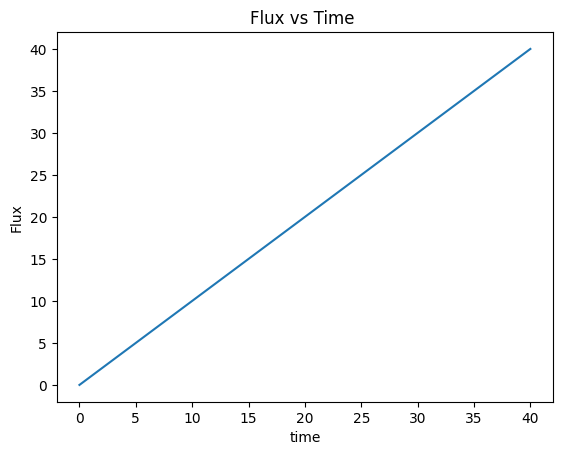

In [ ]:
plt.plot(t,qR)  
plt.xlabel('time')  
plt.ylabel('Flux')  
plt.title(f'Flux vs Time ')     

plt.show() 

The flux applied at the right end of the bar is linearly varying with time t as shown in the graph above.

 SOME VERIFICATIONS

In [ ]:
nnod = x.size
ntime = t.size
if u0.size != nnod:
    raise Exception("Bad definition of function f_u0")
if s.shape[0] != nnod:
    raise Exception("Bad definition of function f_s")
if uL.size != ntime & uL.size != 0:
    raise Exception("Bad definition of function f_uL")
if uR.size != ntime & uR.size != 0:
    raise Exception("Bad definition of function f_uR")
if qL.size != ntime:
    raise Exception("Bad definition of function f_qL")
if qR.size != ntime:
    raise Exception("Bad definition of function f_qR")

## Full Model

 SOLVE: LINEAR FINITE ELEMENTS & SINGLE STEP 1st ORDER TIME INTEGRATION

### Exercise 1: Test the input arguments and plot the results

In [ ]:
uFEM1 = HT1D_FEM_SS11(x, t, k, rho, cp, u0, uL, uR, qL, qR, s, theta)
np.savetxt("Full_Solution2.txt", uFEM1, delimiter=',') 

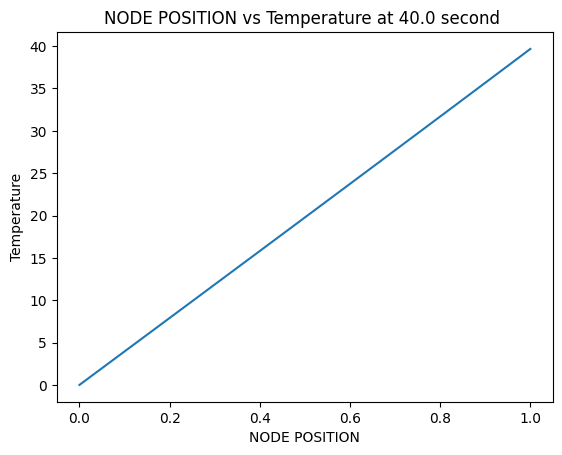

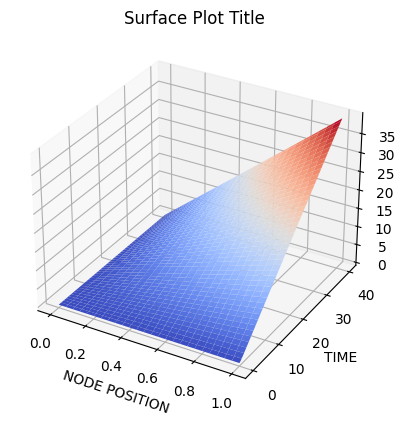

In [ ]:
m = 500                                                
plt.plot(x,uFEM1[:,m]) 
plt.xlabel('NODE POSITION')  
plt.ylabel('Temperature')  
plt.title(f'NODE POSITION vs Temperature at {m*0.08} second ')     

plt.show() 
fig = plt.figure()

ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel('NODE POSITION')  
ax.set_ylabel('TIME')  
ax.set_zlabel('TEMPERATURE')  
ax.set_title('Surface Plot Title') 

[X,T] = np.meshgrid(x,t)
ax.plot_surface(X,T,uFEM1.T, cmap=cm.coolwarm)

The objective of the exercise-1 is to verify the results with the given boundary conditions. 
As we can see from the graph, The temperature at the node-0 is zero, which is the provided dirichlet boundary condition. 
The heat flux provided at the right end is varying linearly w.r.t time, which can be visualized from the surface plot.

The effect of the boundary condition at the left end where flux is given as zero can be visualized from the surface plot. 

Verification and validation are part of the FEM analysis to make sure the analysis is good, As the exercise is of one-dimension, we can have the analytical results to verify but for the complex models, the first thing we do is to verify the boundary conditions.

### Exercise 2: 

The flux shown in below figure is applied at right end with Cp = 50

<a href="https://imgbb.com/"><img src="https://i.ibb.co/G5cSzKX/Screenshot-2023-09-24-192938.jpg" alt="Screenshot-2023-09-24-192938" border="0"></a>

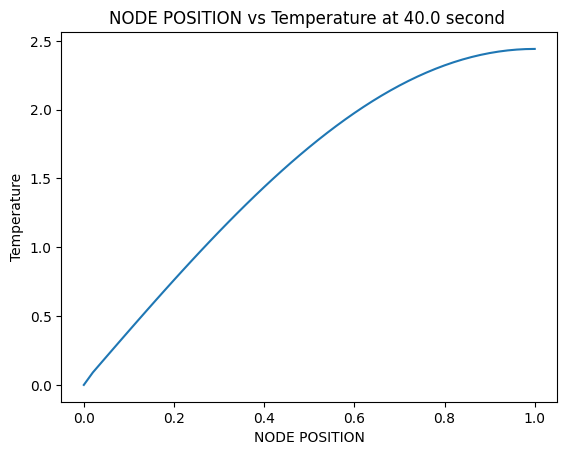

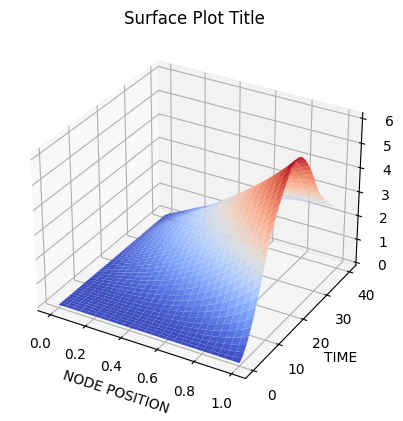

In [ ]:
cp = 50

def f_qR (auxt):
    values = np.zeros_like(auxt)
    values[(t < 30) & (t > 20)] = 30 - t[(t < 30) & (t > 20)]
    values[(t < 20) & (t > 10) ] = 10
    values[t<10] = t[t<10]
    return values

qR = f_qR(t) # qR is recomputed

uFEM = HT1D_FEM_SS11(x, t, k, rho, cp, u0, uL, uR, qL, qR, s, theta)
np.savetxt("Full_Solution.txt", uFEM, delimiter=',') 
n = 500
plt.plot(x, uFEM[:,n])

plt.xlabel('NODE POSITION')  
plt.ylabel('Temperature')  
plt.title(f'NODE POSITION vs Temperature at {n*0.08} second ')  

fig = plt.figure()

ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel('NODE POSITION')  
ax.set_ylabel('TIME')  
ax.set_zlabel('TEMPERATURE')  
ax.set_title('Surface Plot Title') 

#explaination below 2 lines.
[X,T] = np.meshgrid(x,t)
ax.plot_surface(X,T,uFEM.T, cmap=cm.coolwarm)

In exercise-2, We chose the flux at the right end to vary with time as shown in the figure-1.
We find the fem solution and store the solution in Full_Solution.txt and a variable uFEM.

The results are plotted which are respecting the boundary conditions and the surface plot is verified with the given plot in the manual. 

The dip in the temperature from 30 secs is due to the zero flux applied, With the specific heat being 50 the heat diffuses rapidly compared to the case-1. The effect of rapid diffusion can be visualized from the surface plot.

### Exercise 3: Perform only 5 sec and save the result in Init_Sample.

### LEARNING STAGE: Performing full scale solves till 5 seconds

To perform model reduction, we need to train our model with the true data which is from experiments or from the fem analysis. Yes, we have FEM solution for the governing equation, because the analysis is simple say 1D, T = 40 seconds, No source, simple domain etc. What if the domain is complex and it takes days to get the solution from the analyis. 

We perform very few simulations to collect the data to train our model and we come with the best model which takes minutes to give us the solution. The accuracy depends on the size of snaps, quality of the data provided etc.

We need a training set to reduce the order of the model. Therefore, we assume that we only know the solution till 5 seconds. Filter the fem solution from exercise-2 till 5 seconds and store in 'Init_Sample'. So the main objective is to compute the solution till 40 seconds based on the chosen training set using the reduced basis.


In [ ]:
time_limit = 5 
mask = t <= time_limit
uFEM_subset = uFEM[:, mask]
np.savetxt("Init_Sample", uFEM_subset, delimiter=',') 

## POD Routines

The function ComputeRB is used to extract the reduced basis.

From exercise-2, we have Full_Solution2.txt which contains the array of size 51*501. This is representing the true approximated solution using finite element method. Each column of this file is representing how the temperatue is changing w.r.t position at that particular time step. First column corresponds to t = 0 secs, Second to second time step etc.

Now we are going to consider the analysis for 5 seconds (Init_Sample), which we input as parameter uFEM, t is an array of timesteps from 0 to 5 with time step dt. x is representing the array of node numbers, nsnap is the number of snaps we are going to extract from the array t. Threshold, It shows the order of magnitude with which significant modes are considered.

Now using singular value decomposition, we find the significnt modes which are influencing the solution. Weight, which is equal to singular value/(sum of all singular values) are representing the significance of that particular modes. More the weight, more the influence. We use the threshold to filter the modes based on calculated weights. If weights are greater than threshold we store the corresponding left singular vector in RBx.

The significant modes are stored in a text file "POD_RB.txt".

### Linear Dimensional Reduction: Filter the significant modes from the sample

In [ ]:
def computeRB(uFEM, x, t, nsnap, threshold):
    """
    Compute & save Spatial & Time reduced bases.
    uFEM should be of dimensions x.size \times t.size
    nsnap should be less than t.size
    """
    # TAKE SNAPSHOTS IN TIME
    if nsnap > t.size:
        raise Exception(
            f"Number of snapshots {nsnap:d} must not be greater than total time points {t.size:d}"
        )
    mask = np.linspace(0, t.size-1, nsnap, endpoint=True, dtype=int)
    uSNP = uFEM[:, mask]
    # SINGULAR VALUE DECOMPOSITION
    # Hint to complete the line below : Use svd function from linalg module of numpy 
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html#numpy.linalg.svd
    [SingVec, SingVal, _] = np.linalg.svd(uSNP, full_matrices=True, compute_uv=True, hermitian=False) 
    weight = SingVal / SingVal.sum() #[15, 10, 5] --> weight = [0.5, 0.333, 0.166]
    # REDUCED BASIS. ONLY EIGVECTORS FROM EIGENVALUES GREATER THAN THRESHOLD
    RBx = SingVec[:, :len(SingVal[weight >= threshold])]
    np.savetxt("POD_RB.txt", RBx, delimiter=',')

In the above function, mask is selecting equidistant timesteps from 0 to 5 seconds, such that we have 5 snapshots.

We have used the function np.linalg.svd to extract the singular values and vectors. The left singular vectors which are eigen vectors of A.A^T, are stored in SingVec, the singular values which are corresponding eigen_value^2, are stored in SingVal.

weight = SingVal / SingVal.sum() are used to filter the most significant modes comparing to the threshold value.

We filtered the singular vectors based on above said procedure and stored in RBx which is representing the Reduced Basis.

### Build reduced system by Galerkin Projection

The weak form of the governing equation is :
$$
C * \frac{\partial u}{\partial t} + K * u(t) = f(t)
$$

Now we appoximate the solution 
$$
u =  \sum_{i = 1}^{d} \alpha_i B^i
$$ 

$$
u =  B \alpha
$$
Where $B_i$ is the 'i' th column of the reduced bais. $\alpha_i$ is the co-efficients to be computed. The co-efficents are function of time. 

Now substitute u = B $\alpha$  in the governing equation:
$$
C *B* \frac{\partial \alpha (t) }{\partial t} + K*B * \alpha(t) = f(t)
$$

The above equation is over constrained as we have many equations and less unknowns to compute, therefore we project the equation on to the reduced basis to reduce the dimensionality.

$$
B^T * C *B* \frac{\partial \alpha (t) }{\partial t} + B^T * K * B * \alpha(t) = B^T * f(t)
$$

Now we use time marching scheme to compute the $\alpha_i$ vector.

Similar to what we have done earlier, we calculate the value of $\alpha$ at time k+1 assuming the $\alpha$ are known at the time k.

Lets consider 
$$ 
B^T * C *B = C_{red} 
$$
$$ 
B^T * K * B = K_{red} 
$$

And we know f(t) = M s(t) + q(t)

$$ 
B^T * f(t) = B^T * M * s(t) + B^T * q(t) 
$$

$$
s_{red} = B^T * M * s(t)
$$

$$
q_{red} = B^T * q
$$
$$
f_{red} = s_{red} + q_{red}
$$

Now the reultant equation is :

$$
C_{\text{red}} \frac{\partial \alpha(t)}{\partial t} + K_{\text{red}} \alpha(t) = f_{\text{red}}(t)
$$

Now we apply the time marching scheme to find the $\alpha$ : $\theta$ method

$$
C_{\text{red}}\left(\frac{\alpha_{k+1} - \alpha_k}{dt}\right) + K_{\text{red}}\left((\theta \alpha_{k+1}) + (1-\theta) \alpha_k\right) = (\theta f_{\text{red},k+1}) + (1-\theta) f_{\text{red},k}
$$



By interchanging the values: 

$$
\alpha_{k+1} = G_{red}^{-1} b_{red}
$$
 
where, 

$$
b_{\text{red}} = H_{\text{red}} \alpha_k + \Delta t f_{\text{red}}'
$$
$$
H_{\text{red}} = (C_{\text{red}} - (1-\theta) \Delta t K_{\text{red}})
$$

$$
G_{\text{red}} = C_{\text{red}} + \theta \Delta t K_{\text{red}}
$$
$$
f_{\text{red}}' = {f_{\text{red}}}_k + \theta ({f_{\text{red}}}_{k+1} - {f_{\text{red}}}_k)
$$





$ C_{\text{red}}, K_{\text{red}}, f_{\text{red}} $ can be pre-computed.

$ G_{\text{red}}, H_{\text{red}} $ are computed once, depending on the value of $\theta$ and the time step.

$ b_{\text{red}}, f'_{\text{red}} $ are computed at each time step, depending on the values of the previous iteration.

The function `pod` computes the above-explained procedure. It returns `POD_sol`, where:

- `B` is the reduced basis.
- $\alpha$ represents the dimensions `(size_of_reduced_basis, number_of_time_steps)`.


In [ ]:
def pod(uFEM, x, t, k, rho, cp, u0, qL, qR, s, theta, nsnap, threshold):
    """
    Load Spatial reduced bases and compute projected operators (a.k.a. reduced operators)
    Then compute the reduced coefficients by solving the reduced system
    The reduced coefficients are stored as RBt, as they also form the Time basis.
    """

    # LOAD A PRECOMPUTED BASIS, IF IT EXISTS
    if not os.path.exists("POD_RB.txt"):
        raise Exception("POD_RB.txt does not exist.")
    RBx = np.loadtxt("POD_RB.txt", delimiter=",")   

    # SOME VARIABLES FOR CONVENIENCE
    num_nodes = x.size     
    num_time = t.size      

    dt = t[1] - t[0]

    # PROJECT THE FULL ORDER PROBLEM ONTO THE REDUCED BASIS
    # full order matrices & vectors 
    M = FEM_mat_1D(x, 0, 0)
    C = rho * cp * FEM_mat_1D(x, 0, 0)
    K = k * FEM_mat_1D(x, 1, 1)
    q = np.zeros([num_nodes, num_time])  #51*62

    q[0, :] = qL             
    q[-1, :] = qR            
    # projection

    Cred = RBx.T @ C @ RBx
    Kred = RBx.T @ K @ RBx
    
    sred = RBx.T @ M @ s
    qred = RBx.T @ q
    fred = sred + qred
    
    Gred =   Cred + (dt * theta * Kred)                     
    Hred =   (Cred - (Kred*dt*(1 - theta)))                 
    
    fnew = fred[:, 0]

    # SOLVE THE REDUCED ORDER SYSTEM OF ODE
    RBt = np.zeros([RBx.shape[1], num_time])     
        
    RBt[:, 0] = RBx.T @ u0
    
    for i in range(1, num_time):
        fold = fnew
        fnew = fred[:, i]
        f = fold + theta * (fnew - fold)

        bred = (Hred @ RBt[:,i-1]) + f*dt                                   
        
        Unew = np.linalg.solve(Gred, bred)    

        RBt[:, i] = Unew

    POD_sol = [RBx, RBt.T]
    return POD_sol         

### Exercise-5

Now to find the solution at any time, we use the co-efficients of alpha computed at that particular time t in the formula u = B*alpha to find the solution. If the alphas are not computed at any time t, we use interpolation to find the solution.

Now in the off-line stage, the size of the matrix to compute is  for RBx of size [517] where 51 are the nodes and 7 is the reduced basis. But to solve the same in online stage the cost is to compute u by time marching iteratively which is expensive.

Because of the simplicity of the problem we are able to compute the solution using FEM to compare our solution but this is not the case for complex problems. Yes we do need data for training the model, we usually perform very few test to get the data to train the model.

## Plotting Routines

The below functions are:

1. plotPOD --> To compare the solution from Finite Element Formulation and Proper Orthogonal Decomposition
    uPOD is the solution from the reduced basis using Proper Orthogonal Decomposition.
2. plotSpaceTime --> The surface plot to see how the dependent variable is changing w.r.t time and space.
3. plotSpaceTimeModes --> The spacial and temporal modes represent how the system's behavior varies over space and time.

In [ ]:
def plotPOD():
    """Plot FEM & POD solution, POD modes"""
    ## RECONSTRUCT POD SOLUTION 
    uPOD = mPOD[0] @ mPOD[1].T    
    sample = np.linspace(0, t.size-1, min(10, t.size), endpoint=True, dtype=int)
    for i in range(0, sample.size):
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax1.grid()
        ax1.set_ylim([0.95 * uFEM.min(), 1.05 * uFEM.max()])
        ax1.set_xlabel("length (x)")
        ax1.set_ylabel("temperature")
        ax2 = fig.add_subplot(122)
        ax2.grid()
        ax2.set_ylim([0.95 * uPOD.min(), 1.05 * uPOD.max()])
        ax2.set_xlabel("length (x)")
        ax2.set_ylabel("temperature")
    
        ax1.plot(x, uFEM[:, sample[i]])
        
        ax1.set_title(f"Full order t = {t[sample[i]]:.2f}")
        ax2.plot(x, uPOD[:, sample[i]])
        
        ax2.set_title(f"POD t = {t[sample[i]]:.2f}")
        
        fig.canvas.draw()
        plt.pause(0.5)
        

def plotSpaceTime():
    """Plot SPACE-TIME Solution"""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    [X, T] = np.meshgrid(x, t)
    ax.plot_surface(X, T, mPOD[1] @ mPOD[0].T, cmap=cm.coolwarm) 
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_zlabel("u")
    plt.show()
    fig.savefig('SpaceTimeSolution.png')

def plotSpaceTimeModes():
    """PLOT SPACE AND TIME POD MODES"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, mPOD[0])                 
    print(mPOD[0].shape)
    ax.set_xlabel("length (x)")
    ax.set_title("normalized space modes")
    ax.grid()
    fig.savefig('SpaceModes.png')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t, mPOD[1] @ np.diag(1 / np.sqrt(np.diag(mPOD[1].T @ mPOD[1]))))
    ax.set_xlabel("time (t)")
    ax.set_title("normalized time modes")
    ax.grid()
    plt.show()
    fig.savefig('TimeModes.png')

## POD Reduced Model

 NUMBER OF SNAPSHOTS

In [ ]:
nsnap = 10

 POD THRESHOLD

In [ ]:
threshold = 1.0e-5

Computing Reduced Basis

In [ ]:
t2 = np.linspace(0, 5, int(5/dt)).T

uFEM_Sample = np.loadtxt("Init_Sample", delimiter=",")

computeRB(uFEM_Sample, x, t2, nsnap,threshold)

 POD COMPUTATION

In [ ]:
mPOD = pod(uFEM, x, t, k, rho, cp, u0, qL, qR, s, theta, nsnap, threshold)

(6, 501)


 OUTPUT & PLOT RESULTS

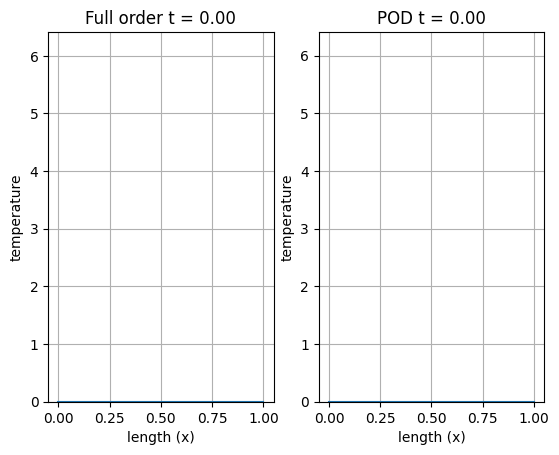

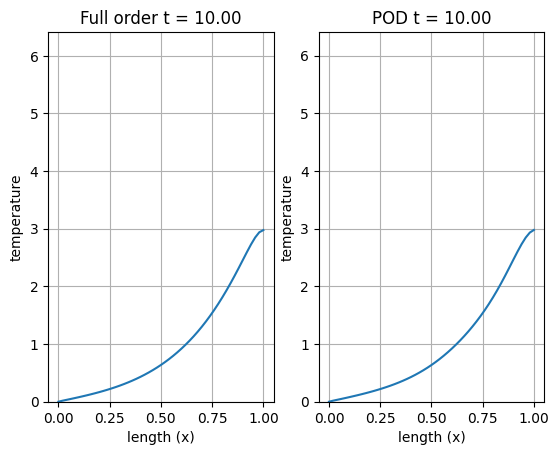

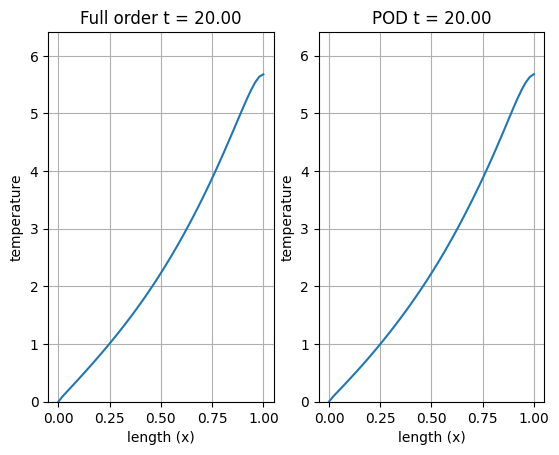

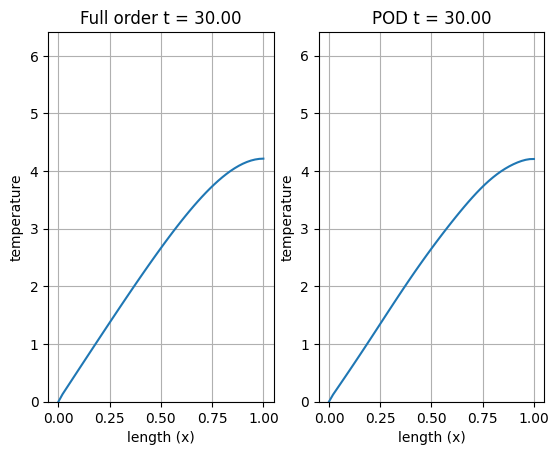

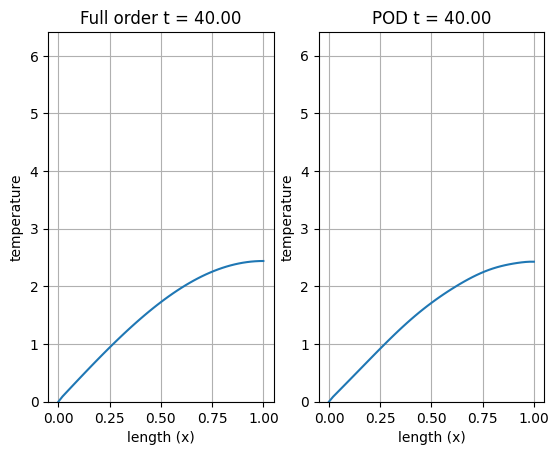

In [ ]:
#%matplotlib widget
#%matplotlib ipympl
#%matplotlib notebook
plotPOD()

The above plots compare the solution obtained from the POD with the FE solution.


![Compare the solutions](https://ibb.co/Z2P3QxC)


The figure is comparing temperature vs position(x) from Finite Element Analysis and POD solution at time = 40 seconds.

We can visualize the accuracy of the solution in the POD approximation. The error is compared below.

The surface plot of (position, time, temperature) is shown below. The surface plot resembles the plot using FE solution.

We can observe the boundary conditions applied, dirichlet boundary of u = 0 at node-0, flux = 0 at node-0 and the variation in flux over the time. The effect of diffusion due to high Cp can be visualized. 

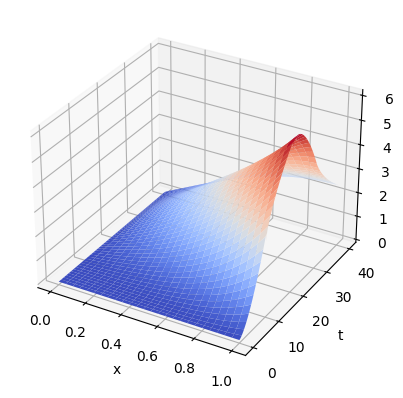

In [ ]:
plotSpaceTime()

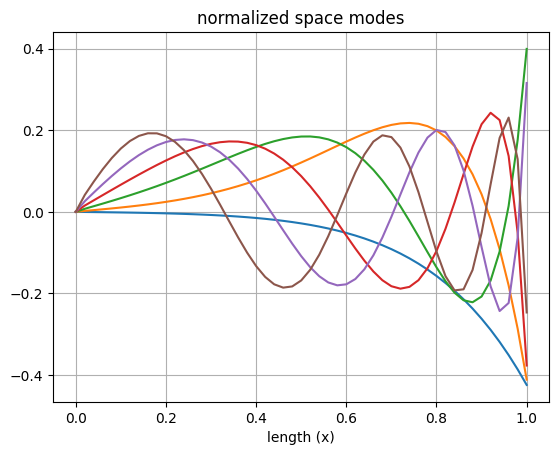

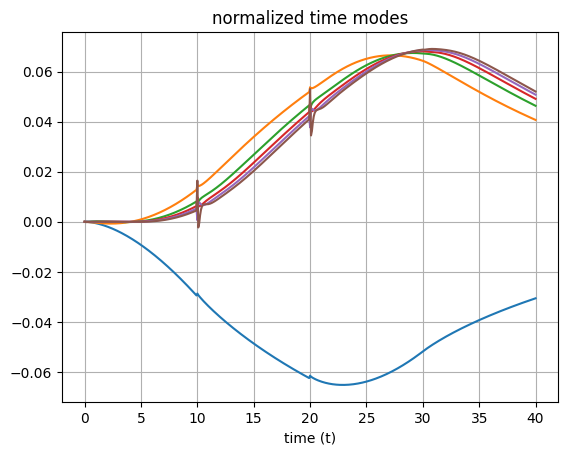

In [ ]:
plotSpaceTimeModes()

Normalized Space Modes:
These are spatial modes derived from the POD analysis. Reduced basis are the best modes that captures the information. Mathematically the best functions with significant information of the data. These spatial modes are plotted by normalizing to have a unit norm. The plot shows the spatial patterns of variations in the data.

Normalized Time Modes: 
These are temporal modes derived from the POD analysis. The temporal modes represent how the system's behavior varies over time. These temporal modes are plotted by normalizing to have a unit norm. The plot shows the temporal patterns of variations in the data.            

These plots visually represent how the system's spatial and temporal behavior can be decomposed into a set of normalized modes, which capture the most significant variations in the data. 

In normalised time modes, one mode stands out as significatly different. This behavior may represent the fundamental behavior of the system, may represent the outlier which contains the noise, may be due to insufficient data.

### ERROR ANALYSIS

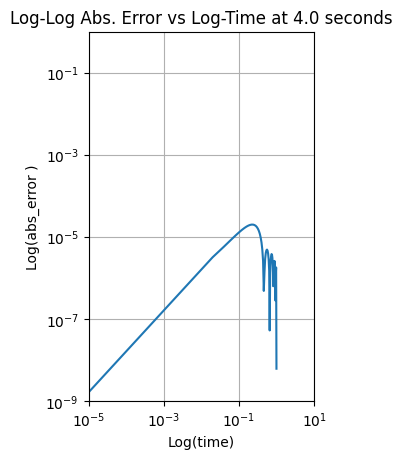

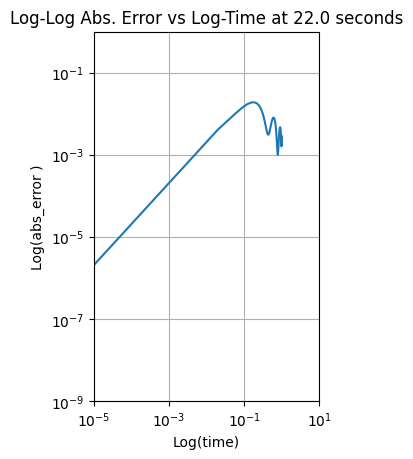

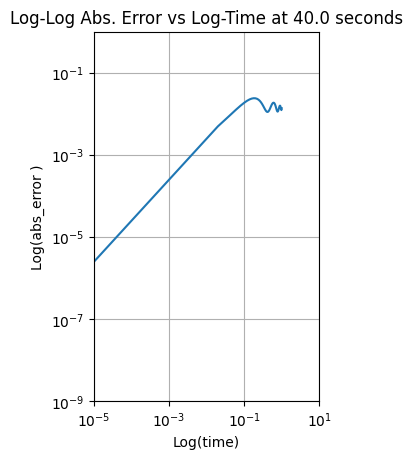

In [ ]:
uPOD = mPOD[0] @ mPOD[1].T  

abs_error = np.abs(uFEM - uPOD) 

sample = np.linspace(50, t.size - 1, min(3, t.size), endpoint=True, dtype=int)

for i in range(0, sample.size):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.grid()
    x_min = 1e-5  
    x_max = 1e1
    y_min = 1e-9 
    y_max = 1e-0
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    
    ax1.set_xlabel("Log(time)")
    ax1.set_ylabel("Log(abs_error )")
    ax1.set_title(f"Log-Log Abs. Error vs Log-Time at {sample[i] * 0.08} seconds")
    ax1.set_xlim([x_min, x_max])
    ax1.set_ylim([y_min, y_max])
    ax1.plot(x, abs_error [:, sample[i]])

    fig.canvas.draw()
    plt.pause(0.5)


From the above log-log plot of absolute error vs time shows how the error is varying. The error of magnitude 10-6 can be seen in the training set, The error is seen high with magnitude of 10-2 in the fore-casted solution. To visualize better a surface plot is shown below.

### Surface plot of absolute error

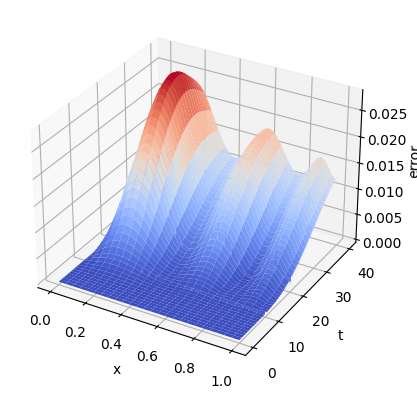

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
[X, T] = np.meshgrid(x, t)
error = np.abs(uFEM - uPOD)

ax.plot_surface(X, T,error.T  , cmap=cm.coolwarm)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("error")
plt.show()

From the above graph, we can visualize how the error is varying is varying w.r.t space and time.

The training set is collected from the first 5 seconds where the error is negligible, The  max.error of maginitude 0.025 can be seen at the left end of the bar where the dirichlet boundary condition is provided and the flux of zero maginitude is provided. Overall there is a significant error in the forecasted data which can be controlled by certain parameters.

### CONCLUSION

A posteriori model reduction is performed using Reduced Basis and Proper Orthogoal Decomposition with time as a parameter for the study.

In the off-line stage which is time consuming, True solution samples are collected and the Singular Value Decomposition is used to find the best modes capturing the charecteristics of the analysis. Now that the reduced basis is available, we approximate the dependent variable using the reduced basis which lead to a over-constrained system. By projecting the Full model onto the reduced basis called Galerkin Projection, Reduced system is attained. 

Using the reduced system in the Online stage, the desired solution is attained in real-time. 

The parameters that control th accuracy are the number of snaps collected, the threshold used. Apart from that, the quality of training data collected matters the most. For the complex analysis, collecting huge data for the stage of learning is costly, therefore we compromise with accuracy to certain extent, by gaining the time. The physics behind the analysis is not compromised.

In this project, 
by considering 10 snaps with the threshold as 10-5, the highest absolute error of 0.025 is attained which is considerable.
by considering 5 snaps with the threshold as 10-5, the highest absolute error of 0.2 is attained.
by considering 10 snaps with the threshold as 10-3, the highest absolute error of 0.8 is attained.
by considering 5 snaps with the threshold as 10-3, the highest absolute error of 0.8 is attained.

The usual case, more the snaps and the threshold is low, high is the accuracy. Depending on the type of analysis, the complexity invloved, computational expense, time and desired accuracy, we chose the appropriate number of snaps and the threshold value.

Systematic approach to help in choosing appropriate number of snaps and threshold.
1. Objective: What is the primary goal of the analysis: reducing computational cost or simplifying complex data.
2. Evaluate the data: Understand the nature of the data, its size, dimensionality and noise level.
3. Snapshot selection: Use the a posteriori error estimate to explore the parametric domain. 
4. threshold selection: It depends on the application and the balance between the accuracy and computational efficiency. We can control this parameter to find a balance.
5. Cross-Validation: Assess the model accuarcy using different snaps and thresholds. 



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6023cfa5-0a13-4ced-89e3-71b8a3c95bde' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>